In [32]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.manifold import TSNE

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from functools import partial

In [8]:
data_s = pd.read_csv('../../data/modelers_data_encoded_scaled.csv')
data = pd.read_csv('../../data/modelers_data.csv')
mask = data.resolution_width <= data.resolution_height
data.loc[mask,["resolution_width","resolution_height"]] = data.loc[mask,["resolution_height","resolution_width"]].values

# Funkcje do wykresów 

In [35]:
def tsne_plot(df,ys,r,c,predictions_title):
    df_copy = df.copy()
    tSNE = TSNE(random_state=60, verbose=1,n_iter=10000)
    digits_proj = tSNE.fit_transform(df_copy)

    figure,ax = plt.subplots(r,c,figsize=(20,10))
    ax = ax.flatten()
    predictions = ys
    predictions_title = predictions_title
    for i in range(len(predictions)):
        sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=predictions[i],palette='viridis',ax=ax[i])
        ax[i].set_title(predictions_title[i])
    plt.show()
def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1],
                    c=palette[colors.astype(int)])
    # plt.xlim(-25, 25)
    # plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add labels
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts

# Transformacjie 

In [2]:
class MinMaxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,classes):
         self.scaler = [MinMaxScaler() for _ in range(len(classes))]
         self.classes = classes
         
    def fit(self, X, y=None):
            for i,col in enumerate(self.classes):
                self.scaler[i].fit(X[[col]])
            return self
    
    def transform(self, X, y=None):
        Xc = X.copy()
        for i,col in enumerate(self.classes):
             Xc[col] = self.scaler[i].transform(Xc[[col]])
        return Xc

In [3]:
class transformer_1(BaseEstimator, TransformerMixin):
    
    def fit(self,df,y= None):
        return self
    
    def transform(self,X,y= None):
    
        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        A = X_copy['processor_tier']
        A[A=='celeron'] = 'core i3'
        A[A=='pentium'] = 'core i5'
        A[A=='m1'] = 'core i5'
        A[A=='m2'] = 'core i7'
        mask_other_processor_tier = A=='other'
        A[A=='other'] = '0'
        A = A.apply(lambda x : 0 if len(re.findall(r'\d+', x))==0 else int(re.findall(r'\d+', x)[0]))
        X_copy['processor_tier'] = A
        X_copy['processor_type_other'] = mask_other_processor_tier + 0

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height) 
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])
        

        return X_copy

In [4]:
class transformer_2(BaseEstimator, TransformerMixin):
    
    def fit(self,df,y= None):
        return self
    
    def transform(self,X,y= None):
    
        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        A = X_copy['processor_tier']
        A[A=='celeron'] = 'core i3'
        A[A=='pentium'] = 'core i5'
        A[A=='m1'] = 'core i5'
        A[A=='m2'] = 'core i7'
        mask_other_processor_tier = A=='other'
        A[A=='other'] = '0'
        A = A.apply(lambda x : 0 if len(re.findall(r'\d+', x))==0 else int(re.findall(r'\d+', x)[0]))
        X_copy['processor_tier'] = A
        X_copy['processor_type_other'] = mask_other_processor_tier + 0

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # Price to log
        X_copy['Price'] = np.log(X_copy['Price'] )

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height) 
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])
        

        return X_copy

In [5]:
class transformer_3(BaseEstimator, TransformerMixin):
    
    def fit(self,df,y= None):
        return self
    
    def transform(self,X,y= None):
    
        X_copy = X.copy()

        # Resolution correction
        mask = X_copy.resolution_width <= X_copy.resolution_height
        X_copy.loc[mask,["resolution_width","resolution_height"]] = X_copy.loc[mask,["resolution_height","resolution_width"]].values

        # Processor tier
        new_column=X_copy['processor_tier'].str.extract(r'(\d)')
        new_column=new_column.fillna(0)
        X_copy['processor_tier']=new_column

        # One Hot Encoding
        diff1 = pd.get_dummies(X_copy[['processor_brand','OS','gpu_brand','gpu_type']],dtype='int')

        # OHEncoding brands
        brands_to_keep = ['hp' , 'lenovo' , 'asus','dell','msi','acer','apple']
        X_copy['brand'] = X_copy['brand'].apply(lambda x: x if x in brands_to_keep else 'other')
        diff2 = pd.get_dummies(X_copy[['brand']],dtype='int')
        X_copy = pd.concat([X_copy,diff1,diff2],axis=1)
        X_copy = X_copy.drop(['index','Model','brand','OS','processor_brand','gpu_brand','gpu_type'],axis=1)

        # Correcting types
        X_copy.is_touch_screen = X_copy.is_touch_screen + 0
        X_copy.primary_storage_type = (X_copy.primary_storage_type=='SSD') + 0

        # Price to log
        X_copy['Price'] = np.log(X_copy['Price'] )

        # year_of_warranty
        mask_year_of_war_no =X_copy.year_of_warranty=='No information'
        X_copy.loc[mask_year_of_war_no,['year_of_warranty']] = 0
        X_copy['year_of_warranty'] = X_copy['year_of_warranty'].apply(lambda x : int(x))
        X_copy['year_of_warranty_other'] = mask_year_of_war_no + 0

        # secondary_storage_type drop
        X_copy = X_copy.drop('secondary_storage_type',axis=1)

        # other transformations 
        X_copy['primary_storage_capacity'] = np.log2(X_copy.primary_storage_capacity)
        X_copy['secondary_storage_capacity'] = X_copy['secondary_storage_capacity'].apply(lambda x : max(0,np.log2(x)))
        X_copy['resolution_width']  = np.log(X_copy.resolution_width)
        X_copy['resolution_height'] = np.log(X_copy.resolution_height) 
        X_copy['Rating'] = X_copy['Rating']/100

        # for i,col in enumerate(self.classes):
        #     X_copy[col] = self.minmax[i].fit_transform(X_copy[[col]])
        

        return X_copy

In [9]:
import warnings 
warnings.filterwarnings('ignore') 

Funkcje do liczenia wyników

In [10]:
def show_metrics(X,model):
    # input:
    # X = przetransformowany dataFrame
    # model = niewytrenowany model
    X = X.values
    y = model.fit_predict(X)
    silhouette = silhouette_score(X, y)
    db_index = davies_bouldin_score(X, y)
    ch_index = calinski_harabasz_score(X, y)  

    return([silhouette,db_index,ch_index])  

def wyniki(model1,model2,model3,n=1):
    # input: 3 niewytrenowane modele
    model_data_ds = data_s.copy()

    classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']
    ppl1 = Pipeline([
        ('transformer',transformer_3()),
        ('minmax',MinMaxTransformer(classess))
    ])
    datatest = data.copy()
    model_data_t1 = ppl1.fit_transform(datatest)

    ppl2 = Pipeline([
    ('transformer',transformer_2()),
    ('minmax',MinMaxTransformer(classess))
    ])
    datatest = data.copy()
    model_data_t2 = ppl2.fit_transform(datatest)

    w1,w2,w3 = [],[],[]

    for i in range(n):
        w1.append(show_metrics(model_data_ds,model1))
        w2.append(show_metrics(model_data_t1,model2))
        w3.append(show_metrics(model_data_t2,model3))

    df = pd.DataFrame({
        "metric" : ["silhouette","davies_bouldin","calinski_harabasz"],
        "data_s" : pd.DataFrame(w1).mean(),
        "transformer_3" : pd.DataFrame(w2).mean(),
        "transformer_2" : pd.DataFrame(w3).mean()
    })

    df.set_index('metric',inplace=True)
    
    return df

Dla podstawowych modeli - baseline

1. GaussianMixture

In [12]:
m = mixture.GaussianMixture(n_components=4, covariance_type="full")
wyniki(m,m,m,50)

  File "c:\Users\jancw\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,data_s,transformer_3,transformer_2
metric,,,
silhouette,0.198226,0.299650,0.292477
davies_bouldin,1.863460,1.508147,1.530092
calinski_harabasz,129.588272,217.822666,213.511548


2. DBSCAN

In [13]:
model_dbscan = DBSCAN(eps=1.41,min_samples=7)
wyniki(model_dbscan,model_dbscan,model_dbscan)

,data_s,transformer_3,transformer_2
metric,,,
silhouette,0.370784,0.506963,0.506274
davies_bouldin,1.268553,1.369540,1.375930
calinski_harabasz,37.385773,99.552272,98.735421


# Szukanie hiperparametrów

Funkcje do customowego gridsearcha

In [14]:
from itertools import product,permutations

def all_combinations(lists):
    return list(product(*lists))

def best_params(lista_wynikow,combinations):
    i = list(lista_wynikow[0]).index(max(list(lista_wynikow[0])))
    print("silhouette : " + f"{lista_wynikow.iloc[i,0]}" + ", comb: " + f"{combinations[i]}")

    i = list(lista_wynikow[1]).index(min(list(lista_wynikow[1])))
    print("davies_bouldin : " + f"{lista_wynikow.iloc[i,1]}" + ", comb: " + f"{combinations[i]}")

    i = list(lista_wynikow[2]).index(max(list(lista_wynikow[2])))
    print("calinski_harabasz : " + f"{lista_wynikow.iloc[i,2]}" + ", comb: " + f"{combinations[i]}")

    print('')

1. GaussianMixture

In [15]:
# definiujemy siatkę parametrów 
param_grid = {
    'n_components': [3, 4, 5, 7],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [1e-3, 1e-4, 1e-5],
    'reg_covar': [1e-6, 1e-5, 1e-4]
}

# definiujemy ramki danych na których działa model
classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']

# 1.
ppl3 = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data3 = ppl3.fit_transform(datatest)
# 2.
ppl2 = Pipeline([('transformer',transformer_2()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data2 = ppl2.fit_transform(datatest)
# 3.
data_s = data_s.copy()

# bierzemy wszystki kombinacje hiperparametrów
combinations = all_combinations(param_grid.values())

# listy list, każda lista ma 3 elementy (wyniki funkcji show_metrics())
best_metrics_t3_gmm = []
best_metrics_t2_gmm = []
best_metrics_ds_gmm = []

# Liczenie wyników
i=1 #i, żeby widzieć ,która iteracja (poglądowo tylko)
for combination in combinations:
    print(i)
    i += 1

    model = mixture.GaussianMixture(n_components=combination[0],
                                     covariance_type=combination[1],
                                     tol=combination[2],
                                     reg_covar=combination[3])
    
    best_metrics_t3_gmm.append(show_metrics(model_data3,model))
    best_metrics_t2_gmm.append(show_metrics(model_data2,model))
    best_metrics_ds_gmm.append(show_metrics(data_s,model))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144


Wyświetlenie najlepszych wyników i kombinacji hiperparam ,dla każdego zbioru danych

In [17]:
best_params(pd.DataFrame(best_metrics_ds_gmm),combinations)
best_params(pd.DataFrame(best_metrics_t3_gmm),combinations)
best_params(pd.DataFrame(best_metrics_t2_gmm),combinations)

silhouette : 0.24642690043318752, comb: (3, 'tied', 0.001, 1e-06)
davies_bouldin : 1.492458752045085, comb: (5, 'spherical', 0.001, 1e-05)
calinski_harabasz : 168.70390071254045, comb: (3, 'diag', 1e-05, 1e-06)

silhouette : 0.35766543821352004, comb: (4, 'tied', 1e-05, 1e-06)
davies_bouldin : 1.0134199729927542, comb: (4, 'tied', 1e-05, 1e-06)
calinski_harabasz : 278.70072873049173, comb: (3, 'full', 1e-05, 0.0001)

silhouette : 0.35769503663951696, comb: (4, 'diag', 0.001, 1e-06)
davies_bouldin : 1.0199112747437673, comb: (4, 'diag', 0.001, 1e-06)
calinski_harabasz : 278.07579025707304, comb: (3, 'full', 0.001, 1e-06)



In [ ]:
# data_ds
# silhouette : 0.24642690043318752, comb: (3, 'tied', 0.001, 1e-06)
# davies_bouldin : 1.492458752045085, comb: (5, 'spherical', 0.001, 1e-05)
# calinski_harabasz : 168.70390071254045, comb: (3, 'diag', 1e-05, 1e-06)
# transformer 3
# silhouette : 0.35766543821352004, comb: (4, 'tied', 1e-05, 1e-06)
# davies_bouldin : 1.0134199729927542, comb: (4, 'tied', 1e-05, 1e-06)
# calinski_harabasz : 278.70072873049173, comb: (3, 'full', 1e-05, 0.0001)
# transformer 2
# silhouette : 0.35769503663951696, comb: (4, 'diag', 0.001, 1e-06)
# davies_bouldin : 1.0199112747437673, comb: (4, 'diag', 0.001, 1e-06)
# calinski_harabasz : 278.07579025707304, comb: (3, 'full', 0.001, 1e-06)

2. DBSCAN

In [69]:
# definiujemy siatkę parametrów 
param_grid = {
    'eps': np.arange(0.1,3,0.01),
    'min_samples': np.arange(2,3),
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15,20,25,30,35]

}

# definiujemy ramki danych na których działa model
classess = ['Price','resolution_width','resolution_height','display_size','processor_tier','num_cores','num_threads',
            'ram_memory','primary_storage_capacity','secondary_storage_capacity']

# 1.
ppl3 = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data3 = ppl3.fit_transform(datatest)
# 2.
ppl2 = Pipeline([('transformer',transformer_2()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data2 = ppl2.fit_transform(datatest)
# 3.
data_s = data_s.copy()

# bierzemy wszystki kombinacje hiperparametrów
combinations = all_combinations(param_grid.values())

# listy list, każda lista ma 3 elementy (wyniki funkcji show_metrics())
best_metrics_t3_dbs = []
best_metrics_t2_dbs = []
best_metrics_ds_dbs = []

# Liczenie wyników
i=1 #i, żeby widzieć ,która iteracja (poglądowo tylko)
for combination in combinations:
    print(i)
    i += 1

    model = DBSCAN(eps=combination[0],
                   min_samples=combination[1],
                   algorithm=combination[2],
                   leaf_size=combination[3])
    
    try:
        best_metrics_t3_dbs.append(show_metrics(model_data3,model))
    except:
        best_metrics_t3_dbs.append([0,float('inf'),0])

    try:
        best_metrics_t2_dbs.append(show_metrics(model_data2,model))
    except:
        best_metrics_t2_dbs.append([0,float('inf'),0])

    try:
        best_metrics_ds_dbs.append(show_metrics(data_s,model))
    except:
        best_metrics_ds_dbs.append([0,float('inf'),0])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [70]:
best_params(pd.DataFrame(best_metrics_ds_dbs),combinations)
best_params(pd.DataFrame(best_metrics_t3_dbs),combinations)
best_params(pd.DataFrame(best_metrics_t2_dbs),combinations)

silhouette : 0.6207797658182845, comb: (1.1599999999999995, 2, 'auto', 15)
davies_bouldin : 0.7884735695455714, comb: (2.289999999999999, 2, 'auto', 15)
calinski_harabasz : 82.01511223734569, comb: (1.3699999999999994, 2, 'auto', 15)

silhouette : 0.5850513951774863, comb: (0.8899999999999996, 2, 'auto', 15)
davies_bouldin : 0.6725880285923879, comb: (2.329999999999999, 2, 'auto', 15)
calinski_harabasz : 130.35521486872628, comb: (1.2899999999999996, 2, 'auto', 15)

silhouette : 0.585041923606201, comb: (0.8899999999999996, 2, 'auto', 15)
davies_bouldin : 0.7465541308679109, comb: (2.549999999999999, 2, 'auto', 15)
calinski_harabasz : 128.34689150472641, comb: (1.2899999999999996, 2, 'auto', 15)



In [ ]:
# data_s
# silhouette : 0.6207797658182845, comb: (1.1599999999999995, 2, 'auto', 15)
# davies_bouldin : 0.7884735695455714, comb: (2.289999999999999, 2, 'auto', 15)
# calinski_harabasz : 82.01511223734569, comb: (1.3699999999999994, 2, 'auto', 15)
# transformer 3
# silhouette : 0.5850513951774863, comb: (0.8899999999999996, 2, 'auto', 15)
# davies_bouldin : 0.6725880285923879, comb: (2.329999999999999, 2, 'auto', 15)
# calinski_harabasz : 130.35521486872628, comb: (1.2899999999999996, 2, 'auto', 15)
# transformer 2
# silhouette : 0.585041923606201, comb: (0.8899999999999996, 2, 'auto', 15)
# davies_bouldin : 0.7465541308679109, comb: (2.549999999999999, 2, 'auto', 15)
# calinski_harabasz : 128.34689150472641, comb: (1.2899999999999996, 2, 'auto', 15)



# Wykresy dla znalezionych hiperparametrów

1. GaussianMixture - pare wybranych wykresów

TRANSFORMER 3

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.996651
[t-SNE] KL divergence after 1000 iterations: 0.168087
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.996651
[t-SNE] KL divergence after 1000 iterations: 0.168087


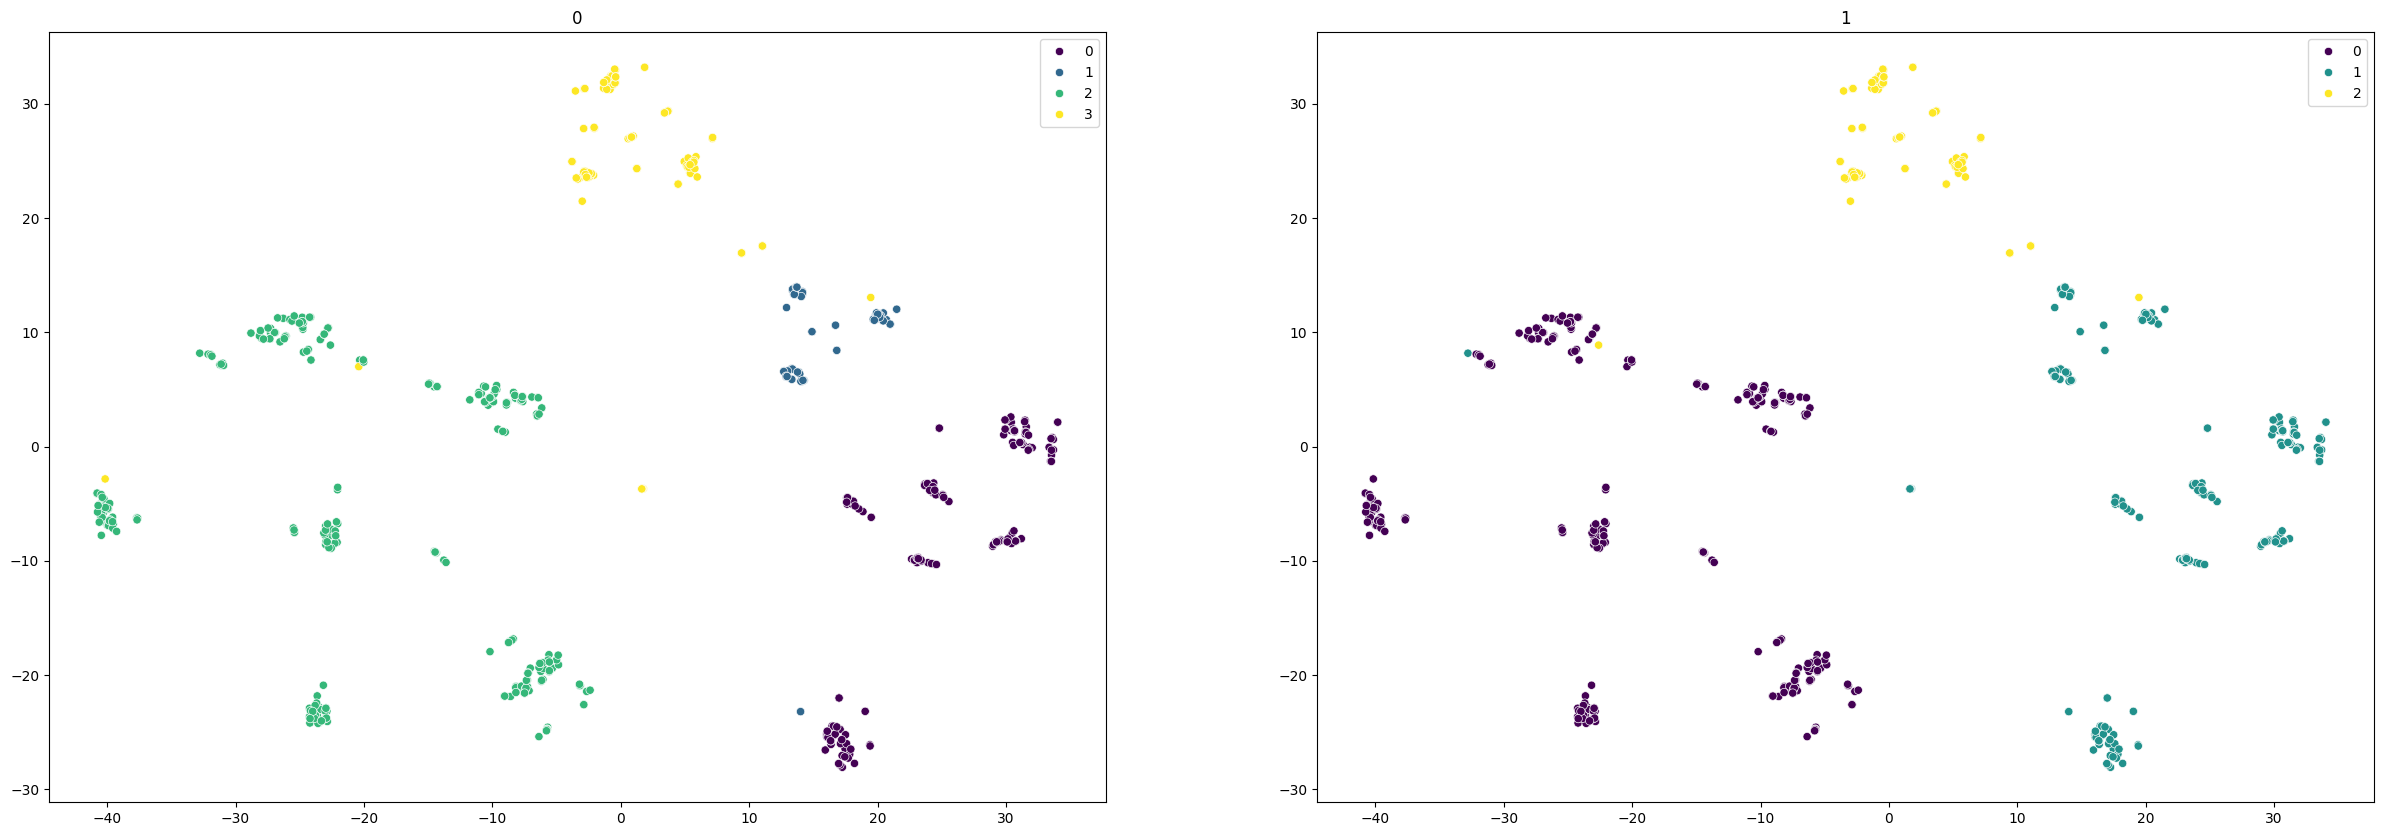

In [66]:
ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
params = [[4, 'tied', 1e-05, 1e-06],[3, 'full', 1e-05, 0.0001]]

figure,ax = plt.subplots(1,2,figsize=(30,10))
ax = ax.flatten()

for i,par in enumerate(params):
    model = mixture.GaussianMixture(n_components=par[0],
                                     covariance_type=par[1],
                                     tol=par[2],
                                     reg_covar=par[3])
    y = model.fit_predict(model_data)
    X_pca =  PCA(n_components=30).fit_transform(model_data)
    digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=y,palette='viridis',ax=ax[i])
    ax[i].set_title(i)

plt.show()

TRANSFORMER 2

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.004s...
[t-SNE] Computed neighbors for 693 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.896599
[t-SNE] KL divergence after 1000 iterations: 0.167207
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.896599
[t-SNE] KL divergence after 1000 iterations: 0.167207


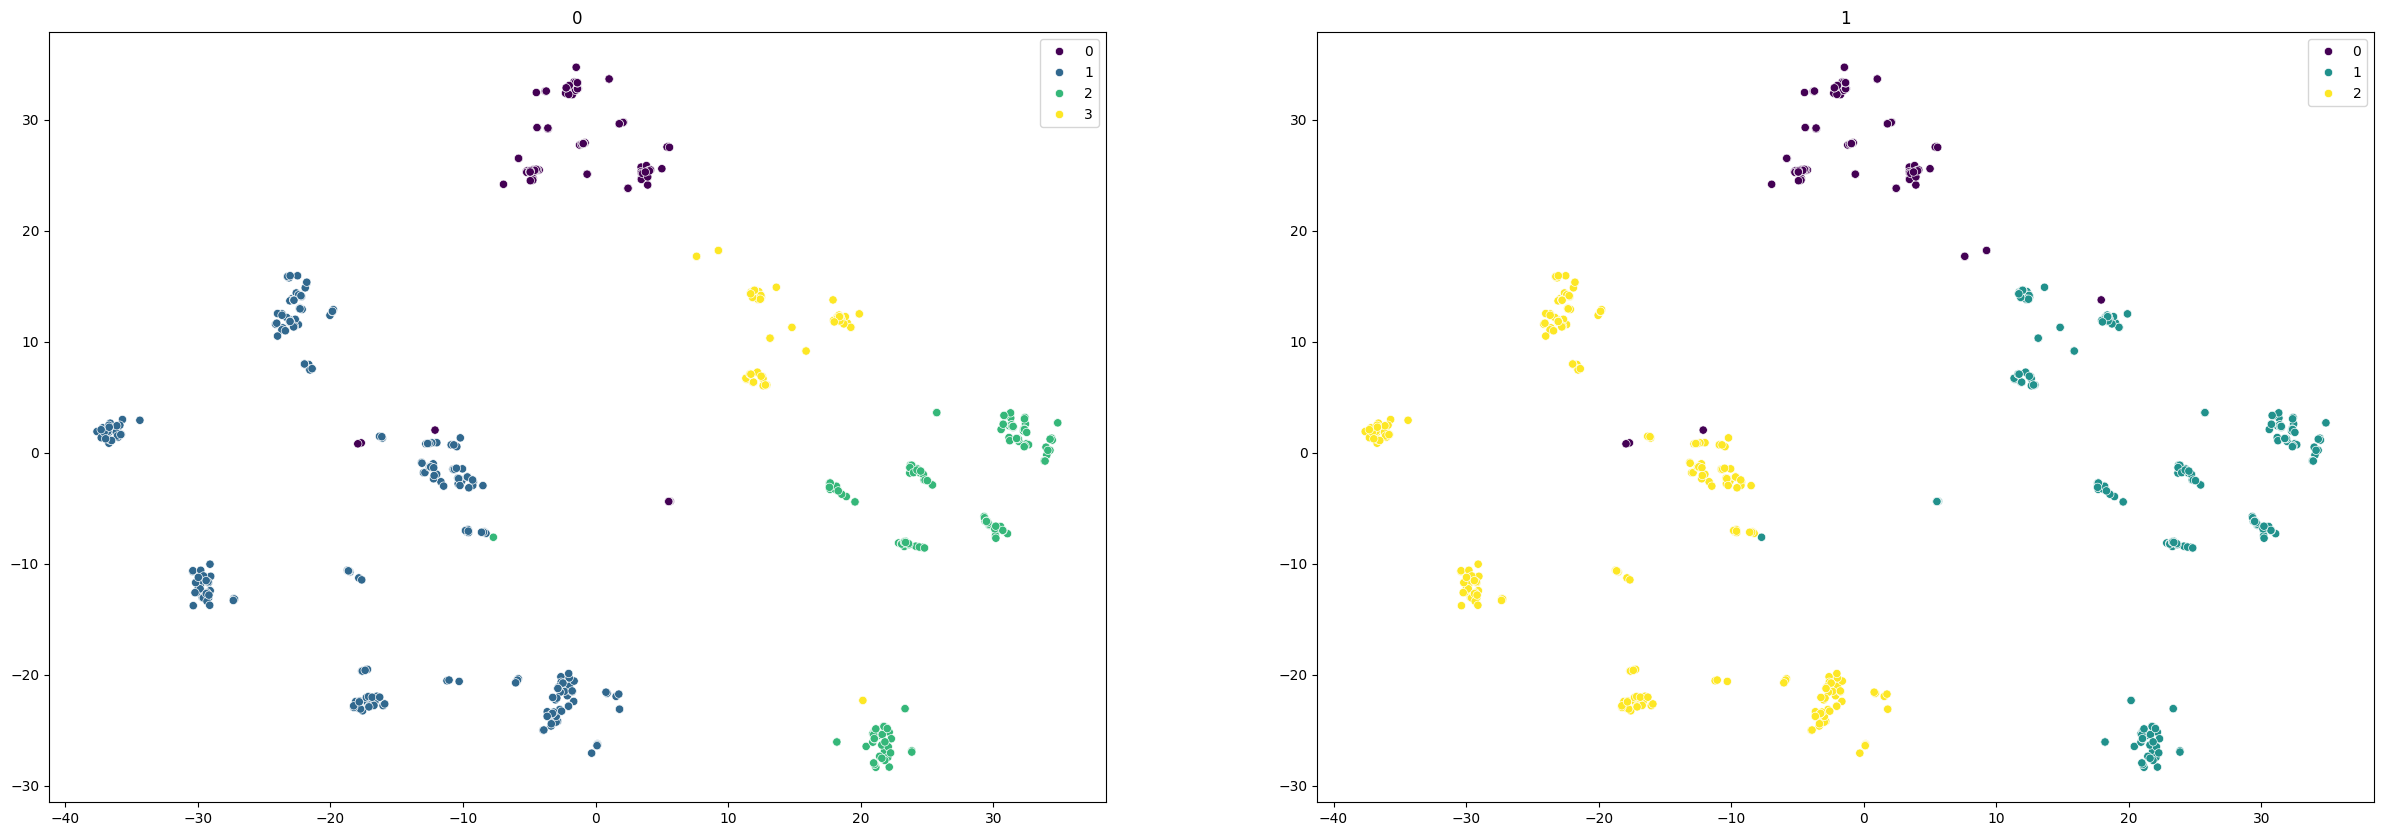

In [67]:
ppl = Pipeline([('transformer',transformer_2()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
params = [[4, 'diag', 0.001, 1e-06],[3, 'full', 0.001, 1e-06]]

figure,ax = plt.subplots(1,2,figsize=(30,10))
ax = ax.flatten()

for i,par in enumerate(params):
    model = mixture.GaussianMixture(n_components=par[0],
                                     covariance_type=par[1],
                                     tol=par[2],
                                     reg_covar=par[3])
    y = model.fit_predict(model_data)
    X_pca =  PCA(n_components=30).fit_transform(model_data)
    digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=y,palette='viridis',ax=ax[i])
    ax[i].set_title(i)

plt.show()

Data_s

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.734007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.249947
[t-SNE] KL divergence after 1000 iterations: 0.234636
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.734007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.236263
[t-SNE] KL divergence after 1000 iterations: 0.233861
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.733753
[t-SNE] KL divergence after 250 iteratio

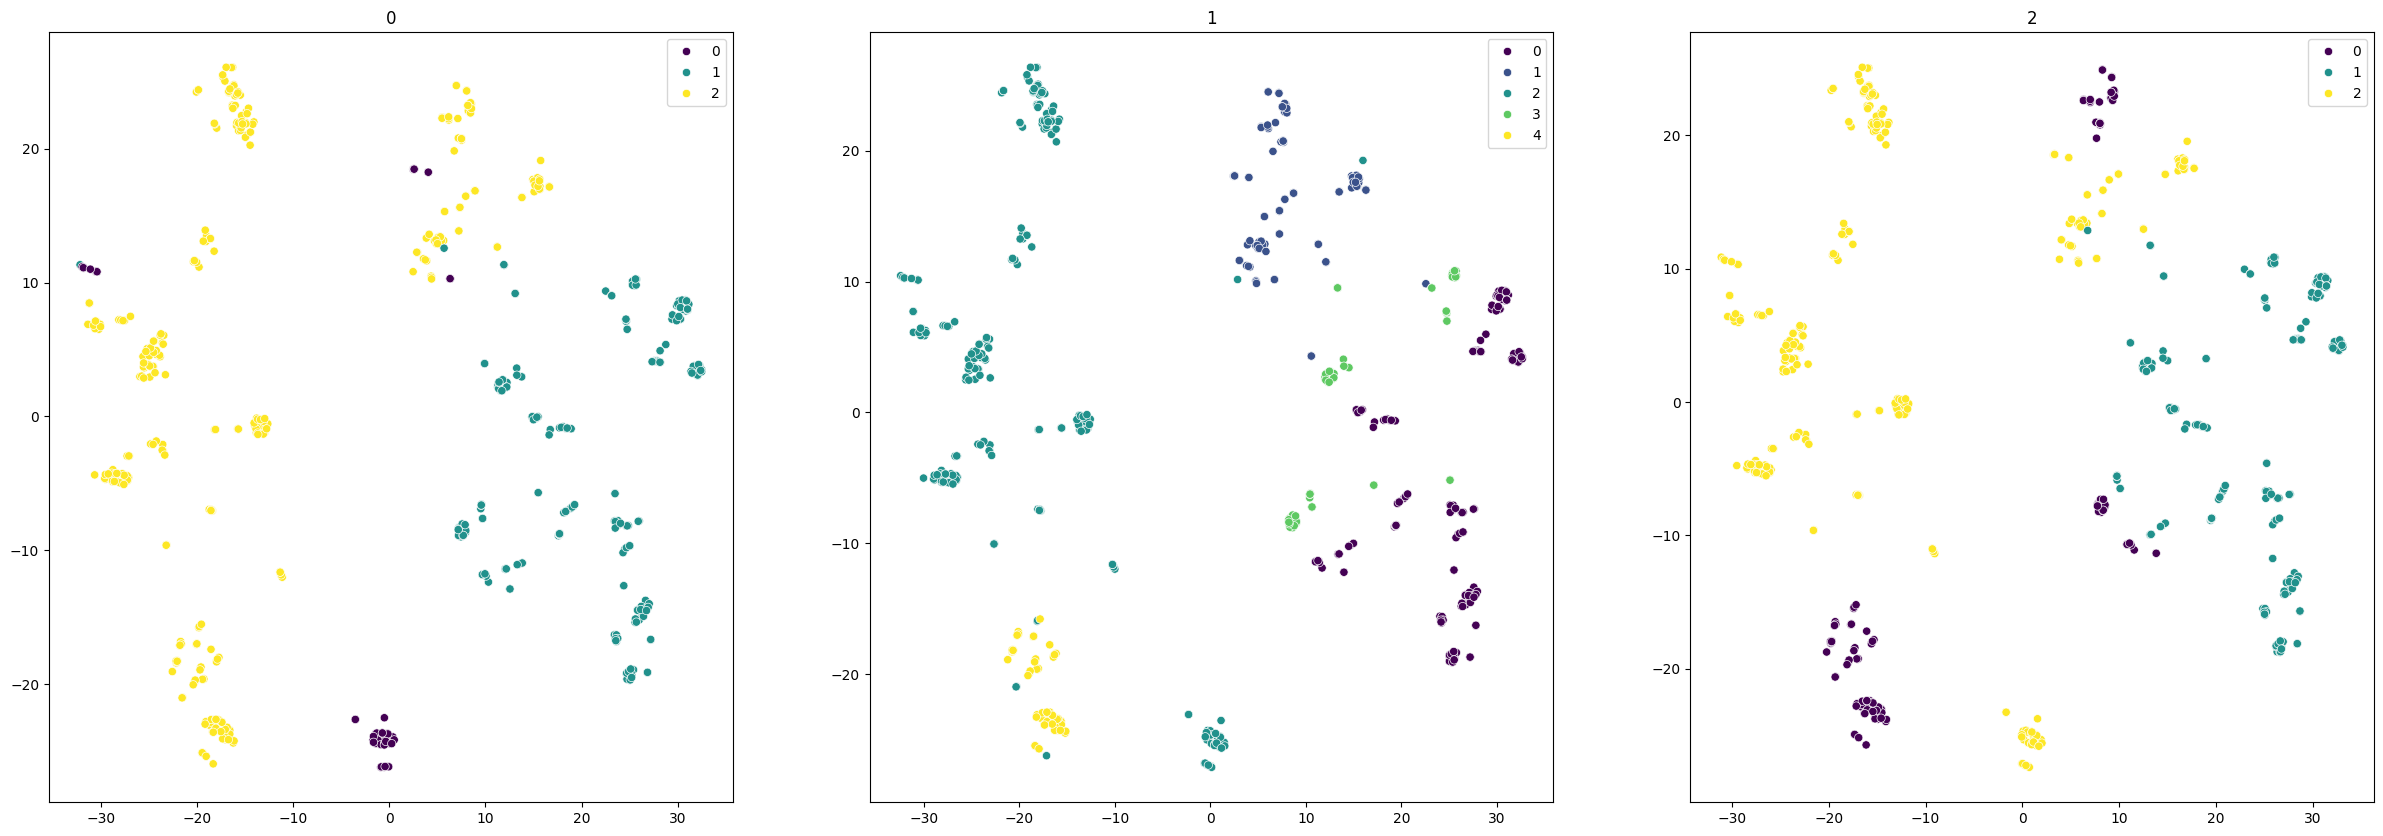

In [68]:
model_data = data_s.copy()
params = [[3, 'tied', 0.001, 1e-06],[5, 'spherical', 0.001, 1e-05],[3, 'diag', 1e-05, 1e-06]]

figure,ax = plt.subplots(1,3,figsize=(30,10))
ax = ax.flatten()

for i,par in enumerate(params):
    model = mixture.GaussianMixture(n_components=par[0],
                                     covariance_type=par[1],
                                     tol=par[2],
                                     reg_covar=par[3])
    y = model.fit_predict(model_data)
    X_pca =  PCA(n_components=30).fit_transform(model_data)
    digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=y,palette='viridis',ax=ax[i])
    ax[i].set_title(i)

plt.show()

Wykresy ze środkami klastrow

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.996651


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.168087


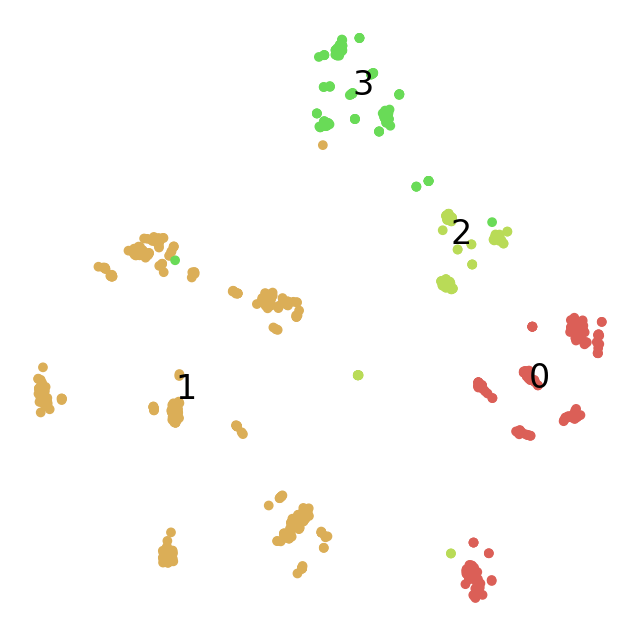

In [38]:
ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model = mixture.GaussianMixture(n_components=4,
                                     covariance_type='tied',
                                     tol=1e-05,
                                     reg_covar=1e-06)
y = model.fit_predict(model_data)
X_pca =  PCA(n_components=30).fit_transform(model_data)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.008831


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.168684


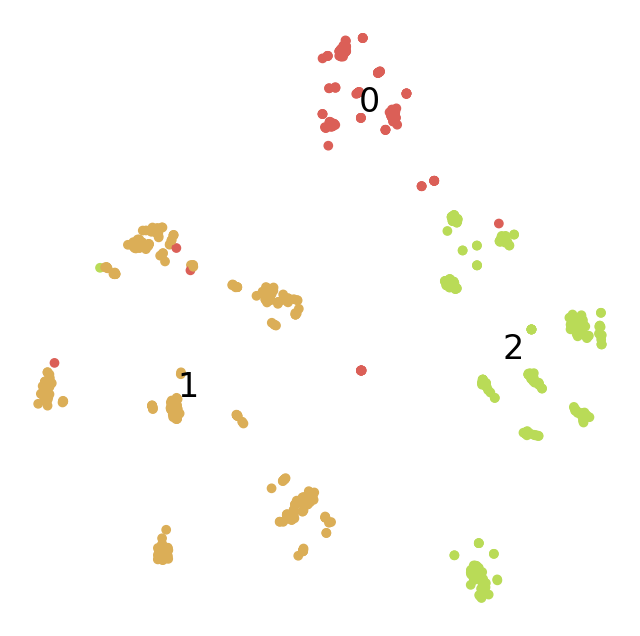

In [37]:
ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model = mixture.GaussianMixture(n_components=3,
                                     covariance_type='full',
                                     tol=1e-05,
                                     reg_covar=0.0001)
y = model.fit_predict(model_data)
X_pca =  PCA(n_components=30).fit_transform(model_data)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.016s...
[t-SNE] Computed neighbors for 693 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.896599


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.167207


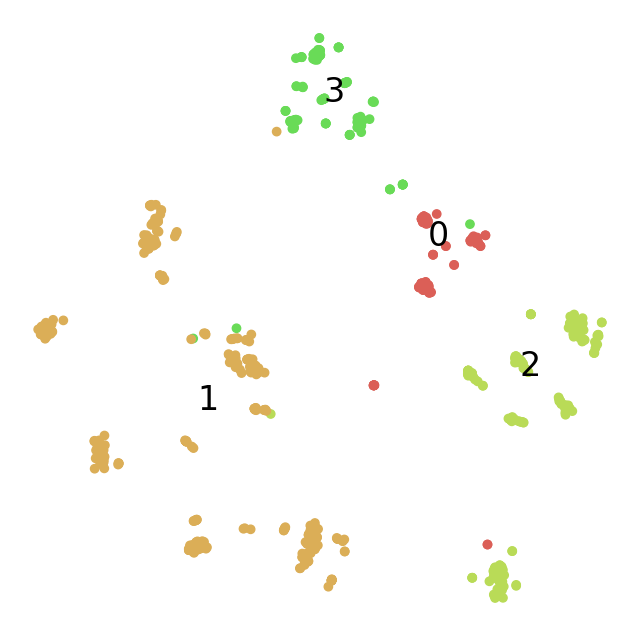

In [40]:
ppl = Pipeline([('transformer',transformer_2()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model = mixture.GaussianMixture(n_components=4,
                                     covariance_type='diag',
                                     tol=0.001,
                                     reg_covar=1e-06)
y = model.fit_predict(model_data)
X_pca =  PCA(n_components=30).fit_transform(model_data)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.733854
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.231358


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.234465


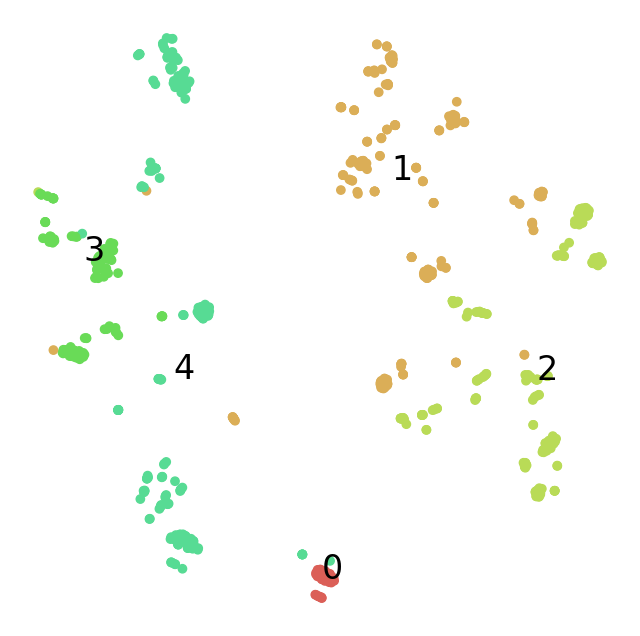

In [43]:
model_data = data_s.copy()
model = mixture.GaussianMixture(n_components=5,
                                     covariance_type='spherical',
                                     tol=0.001,
                                     reg_covar=1e-05)
y = model.fit_predict(model_data)
X_pca =  PCA(n_components=30).fit_transform(model_data)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y)
plt.show()

2. DBSCAN - wybrane wykresy

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.993973
[t-SNE] KL divergence after 1000 iterations: 0.168132
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.993973
[t-SNE] KL divergence after 1000 iterations: 0.168132
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iteratio

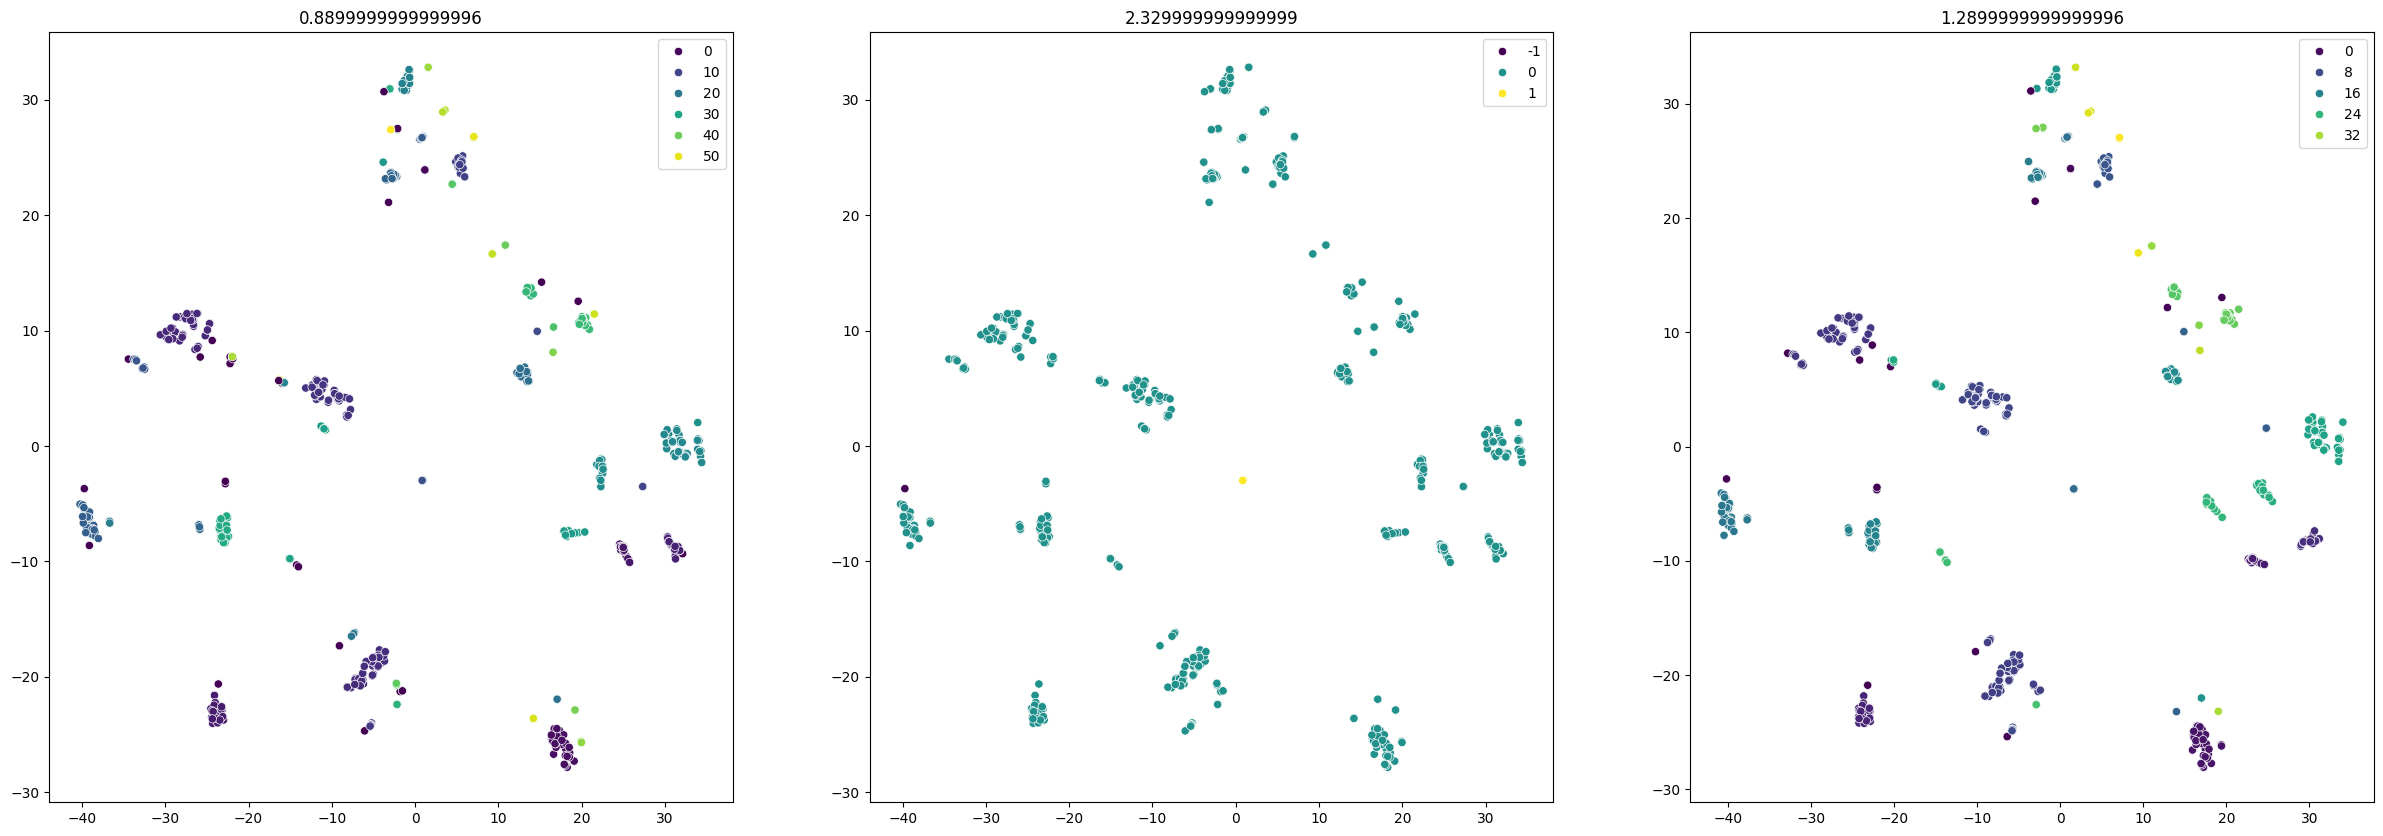

In [65]:
ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
params = [0.8899999999999996,2.329999999999999,1.2899999999999996]

figure,ax = plt.subplots(1,3,figsize=(30,10))
ax = ax.flatten()

for i,par in enumerate(params):
    model = DBSCAN(eps=par,
                    min_samples=2)
    y = model.fit_predict(model_data)
    X_pca =  PCA(n_components=30).fit_transform(model_data)
    digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=y,palette='viridis',ax=ax[i])
    ax[i].set_title(par)

plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.896599
[t-SNE] KL divergence after 1000 iterations: 0.167207
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.896599
[t-SNE] KL divergence after 1000 iterations: 0.167207
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iteratio

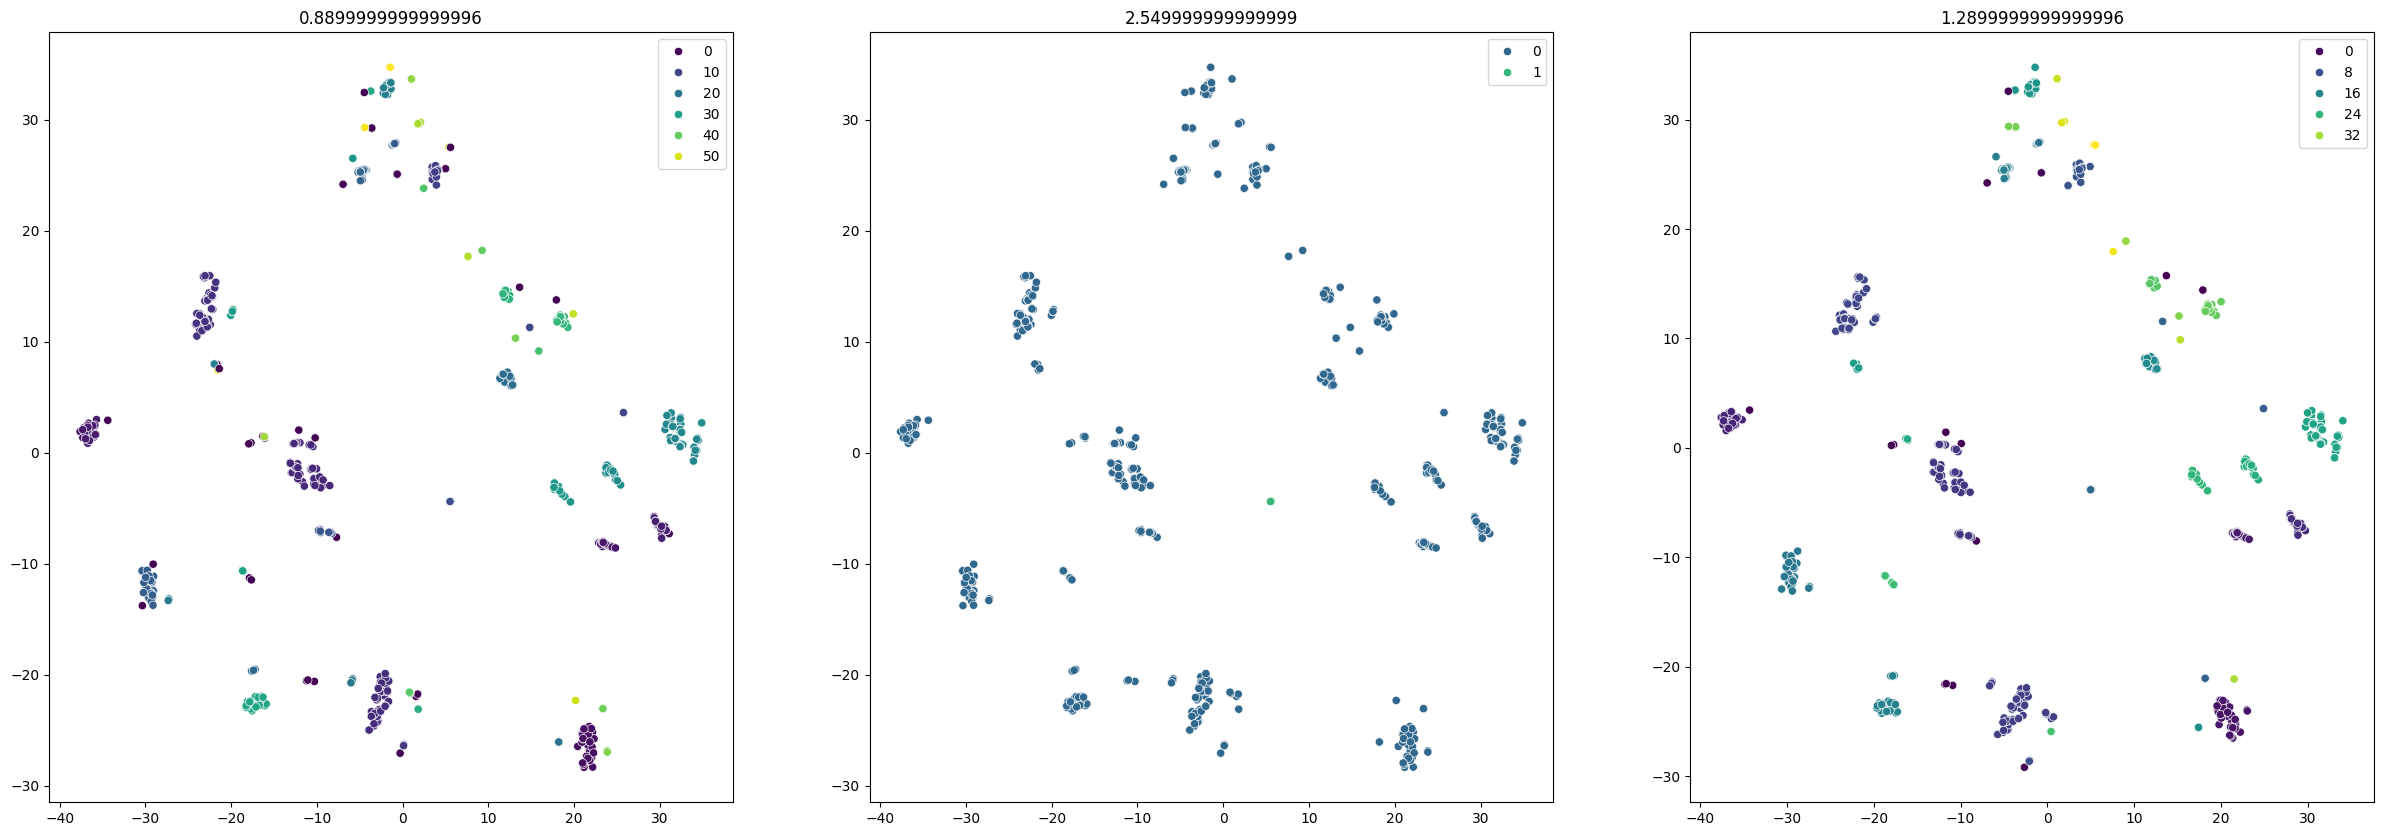

In [63]:
ppl = Pipeline([('transformer',transformer_2()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
params = [0.8899999999999996,2.549999999999999,1.2899999999999996]

figure,ax = plt.subplots(1,3,figsize=(30,10))
ax = ax.flatten()

for i,par in enumerate(params):
    model = DBSCAN(eps=par,
                    min_samples=2)
    y = model.fit_predict(model_data)
    X_pca =  PCA(n_components=30).fit_transform(model_data)
    digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=y,palette='viridis',ax=ax[i])
    ax[i].set_title(par)

plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.734169
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.212482
[t-SNE] KL divergence after 1000 iterations: 0.234558
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.008s...
[t-SNE] Computed neighbors for 693 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.734327
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.221378
[t-SNE] KL divergence after 1000 iterations: 0.235252
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.733777
[t-SNE] KL divergence after 250 iteratio

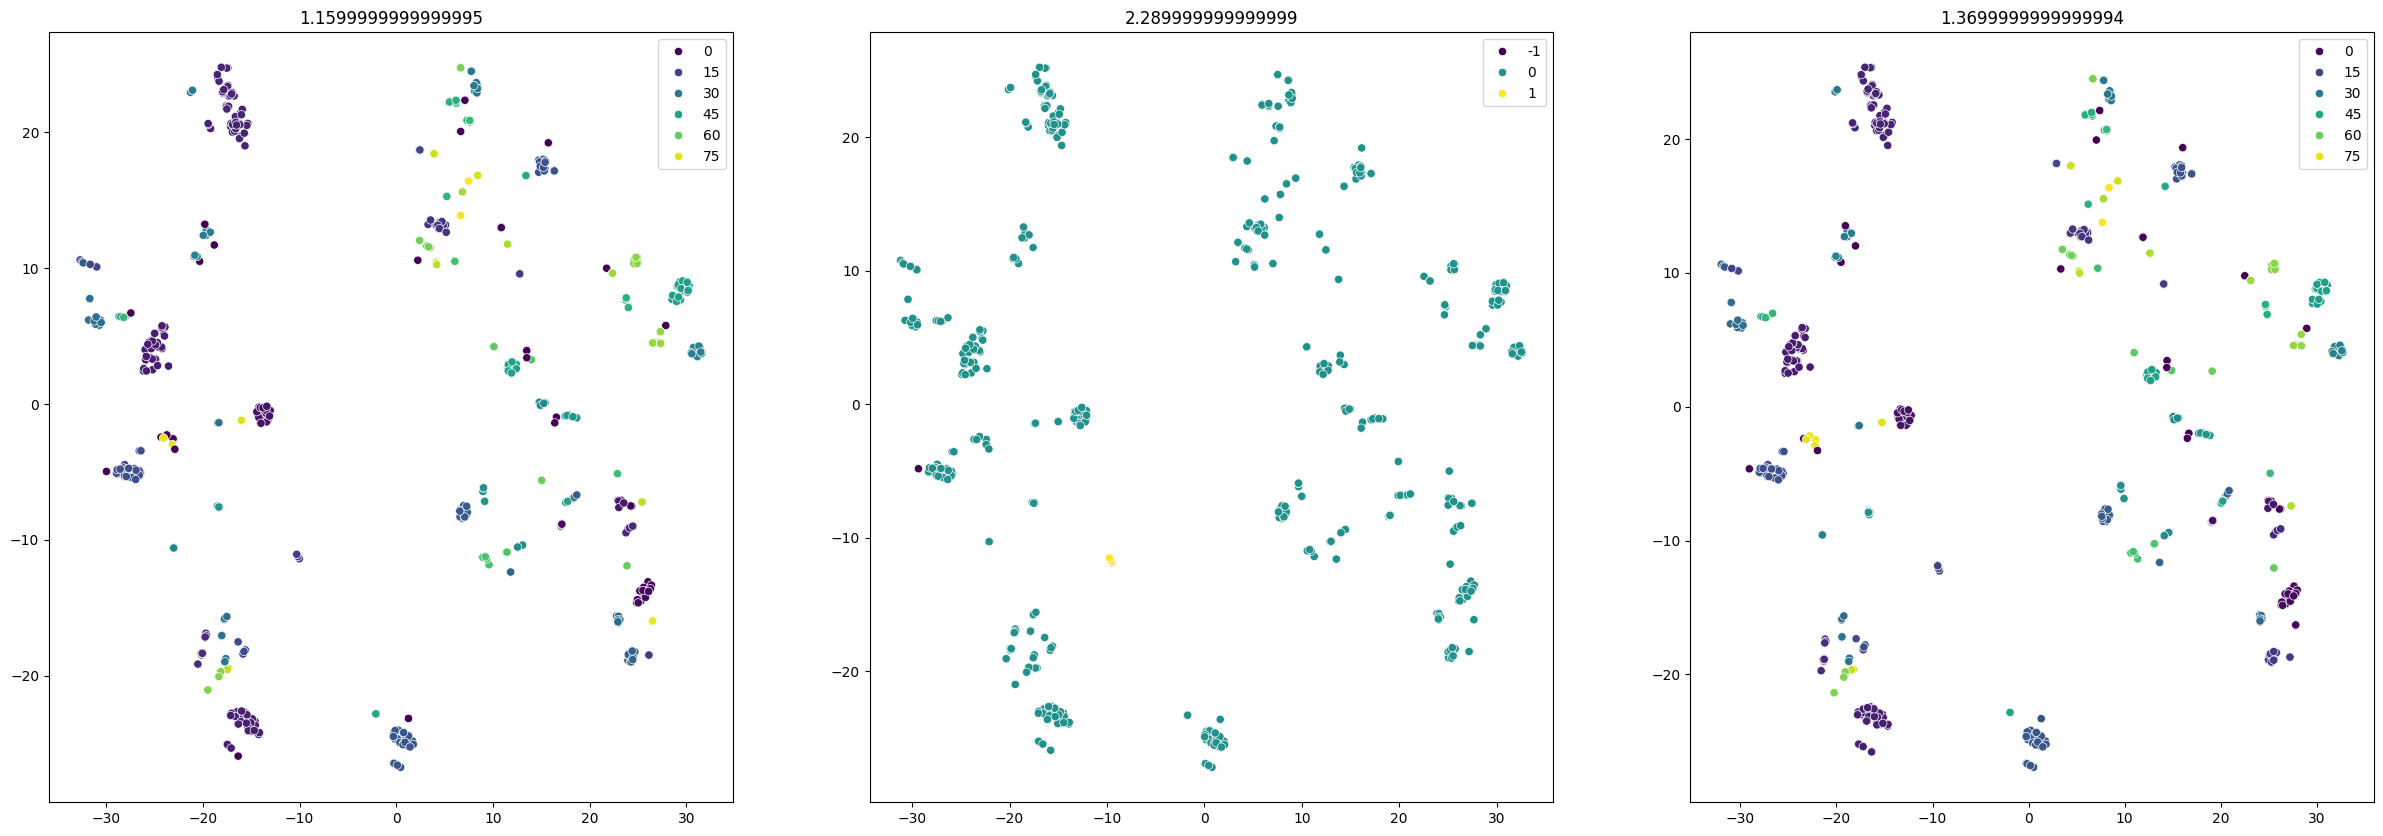

In [64]:
model_data = data_s
params = [1.1599999999999995,2.289999999999999,1.3699999999999994]

figure,ax = plt.subplots(1,3,figsize=(30,10))
ax = ax.flatten()

for i,par in enumerate(params):
    model = DBSCAN(eps=par,
                    min_samples=2)
    y = model.fit_predict(model_data)
    X_pca =  PCA(n_components=30).fit_transform(model_data)
    digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
    sns.scatterplot(x=digits_proj[:,0], y=digits_proj[:,1],hue=y,palette='viridis',ax=ax[i])
    ax[i].set_title(par)

plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.016s...
[t-SNE] Computed neighbors for 693 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.896599


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.167207


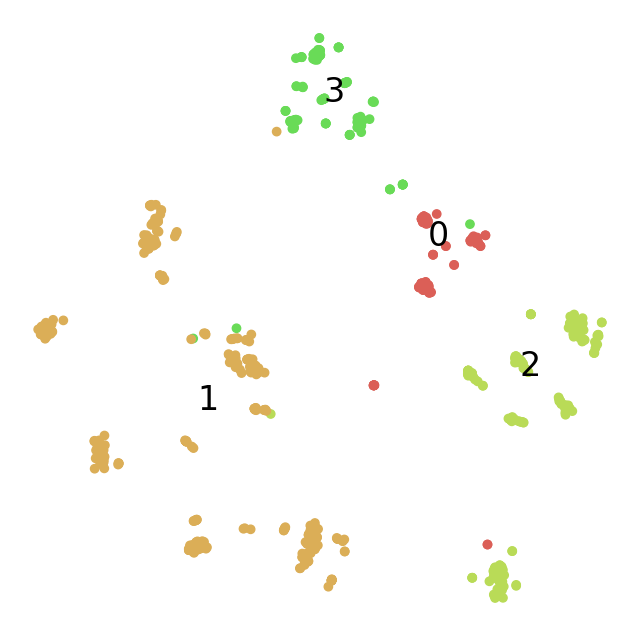

In [ ]:
ppl = Pipeline([('transformer',transformer_2()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model = mixture.GaussianMixture(n_components=4,
                                     covariance_type='diag',
                                     tol=0.001,
                                     reg_covar=1e-06)
y = model.fit_predict(model_data)
X_pca =  PCA(n_components=30).fit_transform(model_data)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.016s...
[t-SNE] Computed neighbors for 693 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.531397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.896599


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.167207


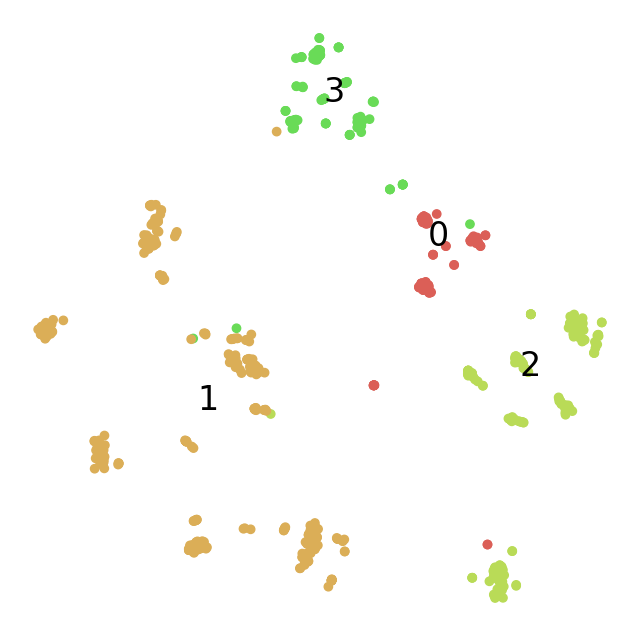

In [ ]:
ppl = Pipeline([('transformer',transformer_2()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model = mixture.GaussianMixture(n_components=4,
                                     covariance_type='diag',
                                     tol=0.001,
                                     reg_covar=1e-06)
y = model.fit_predict(model_data)
X_pca =  PCA(n_components=30).fit_transform(model_data)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 693 samples in 0.000s...
[t-SNE] Computed neighbors for 693 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 693 / 693
[t-SNE] Mean sigma: 0.534469
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.993973


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[t-SNE] KL divergence after 1000 iterations: 0.168132


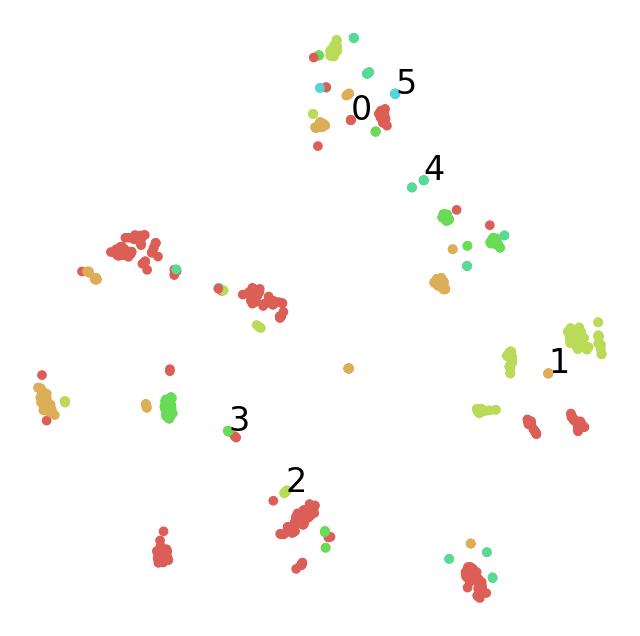

In [50]:
ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model = DBSCAN(eps=0.8899999999999996,
                   min_samples=2)
y = model.fit_predict(model_data)
X_pca =  PCA(n_components=30).fit_transform(model_data)
digits_proj = TSNE(random_state=101, verbose=1,n_iter=1000).fit_transform(X_pca)
scatter(digits_proj, y/10)
plt.show()

# Wnioski z klasteryzacji 

In [71]:
ppl = Pipeline([('transformer',transformer_3()),('minmax',MinMaxTransformer(classess))])
datatest = data.copy()
model_data = ppl.fit_transform(datatest)
model = mixture.GaussianMixture(n_components=4,
                                     covariance_type='tied',
                                     tol=1e-05,
                                     reg_covar=1e-06)
y = model.fit_predict(model_data)

In [96]:
data_nc = data.copy()
data_nc['y'] = y
print(data_nc[['processor_brand','y']].value_counts().reset_index().sort_values('y'))
print("")
print(data_nc[['processor_tier','y']].value_counts().reset_index().sort_values('y'))
print("")
print(data_nc[['gpu_brand','y']].value_counts().reset_index().sort_values('y'))
print("")
print(data_nc[['gpu_type','y']].value_counts().reset_index().sort_values('y'))
print("")
print(data_nc[['OS','y']].value_counts().reset_index().sort_values('y'))

  processor_brand  y  count
3             amd  0     82
0           intel  1    314
2             amd  2    110
4           apple  2      9
5           other  2      2
1           intel  3    176

   processor_tier  y  count
6         ryzen 5  0     38
7         ryzen 7  0     36
12        ryzen 9  0      8
0         core i5  1    141
1         core i3  1     95
17        pentium  1      1
16        core i9  1      3
5         core i7  1     48
8         celeron  1     25
18          other  1      1
15             m2  2      3
14             m3  2      6
13          other  2      6
9         ryzen 7  2     23
10        ryzen 3  2     21
4         ryzen 5  2     62
3         core i7  3     65
2         core i5  3     90
11        core i9  3     20
19   core ultra 7  3      1

  gpu_brand  y  count
3    nvidia  0     72
4       amd  0     10
0     intel  1    313
7       amd  1      1
2       amd  2    109
5     apple  2      9
6       arm  2      2
8     intel  2      1
1    nvidia  3  

<Axes: xlabel='display_size', ylabel='Density'>

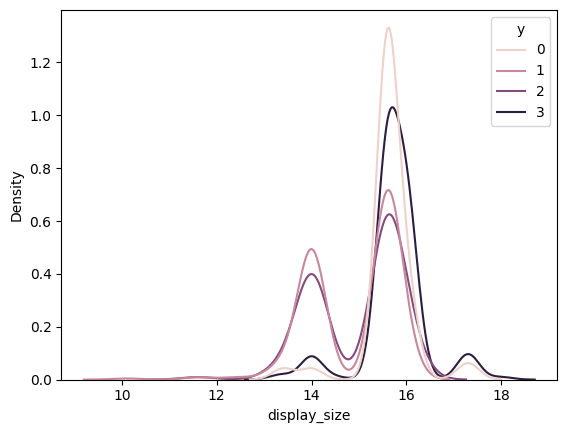

In [100]:
sns.kdeplot(data=data_nc,x='display_size',hue='y',common_norm=False)

<Axes: xlabel='resolution_height', ylabel='Density'>

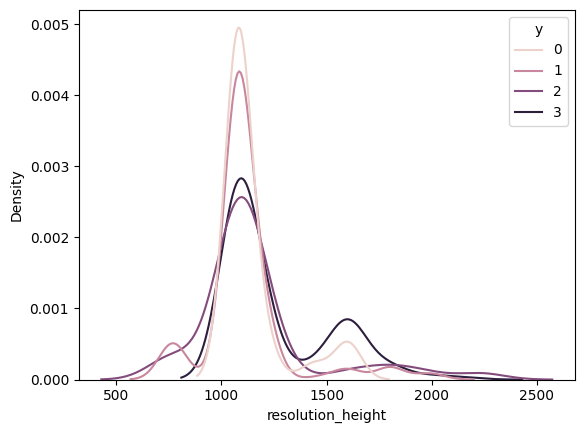

In [102]:
sns.kdeplot(data=data_nc,x='resolution_height',hue='y',common_norm=False)

<Axes: xlabel='resolution_width', ylabel='Density'>

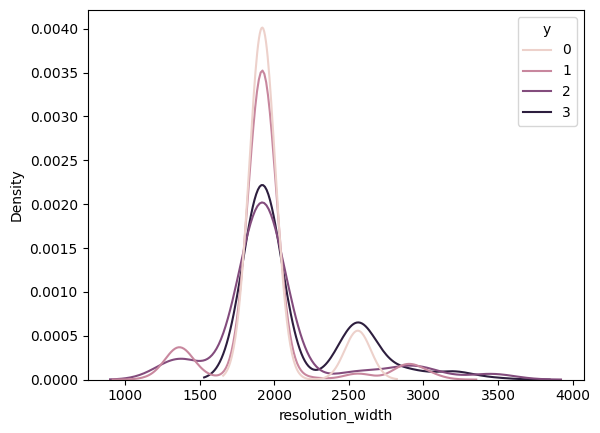

In [107]:
sns.kdeplot(data=data_nc,x='resolution_width',hue='y',common_norm=False)